## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5-1. Modeling 1 - RPI Prediction - XGBoost

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression

In [4]:
import pickle 

import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats

from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [13]:
%store -r y_RPI
%store -r y_RPI_2019
%store -r X_famd
%store -r X_famd_2019
%store -r X_College
%store -r X_College_2019
%store -r X_2019
%store -r X

In [23]:
columns_categorical = X.columns[list(range(16,48))]
columns_categorical
for idx,col in enumerate(columns_categorical):
    X[col] = X[col].astype(int)
    X_2019[col] = X_2019[col].astype(int)

print(X.dtypes)
print(X_2019.dtypes)

Year                                 float64
Fielding_Percentage                  float64
Scoring                              float64
Hit_Batters                          float64
Earned_Run_Average                   float64
Triples_per_Game                     float64
Home_Runs_per_game                   float64
Slugging_Percentage                  float64
Double_Plays_per_Game                float64
On_Base_Percentage                   float64
Stolen_Bases_per_Game                float64
Strikeout-to-Walk_Ratio              float64
Batting_Average                      float64
Doubles_per_Game                     float64
Shutouts                             float64
Team_Strikeouts_Per_Seven_Innings    float64
Conf__ACC                              int64
Conf__ASUN                             int64
Conf__America East                     int64
Conf__Atlantic 10                      int64
Conf__Big 12                           int64
Conf__Big East                         int64
Conf__Big 

In [24]:
X = X.drop(columns=['Year'])
X_2019 = X_2019.drop(columns=['Year'])

In [25]:
y_RPI.to_csv('Data/y_RPI.csv',index=False)
y_RPI_2019.to_csv('Data/y_RPI_2019.csv',index=False)
X.to_csv('Data/X.csv',index=False)
X_2019.to_csv('Data/X_2019.csv',index=False)
X_famd.to_csv('Data/X_famd.csv',index=False)
X_famd_2019.to_csv('Data/X_famd_2019.csv',index=False)
X_College.to_csv('Data/X_College.csv',index=False)
X_College_2019.to_csv('Data/X_College_2019.csv',index=False)

In [6]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [46]:
y = y_RPI
X = X_famd.copy()
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
297,2.170850,-0.027647,0.127369,1.219246,0.368641,-0.196787,-0.130418,-0.171609,-0.352457,0.058697,-0.383129,0.073038,1.005647,0.595547,0.468127,-0.074023,-0.904480,0.720769,-0.207444,-0.485857,-0.214408,-0.676500,-0.153969,-0.128498,-0.310688,-0.043215,0.134537,0.032437,-0.287246,0.018377,0.098459,-0.270373,-0.335707,-0.448651,0.572197,0.410523,-0.068122,-0.046195,0.043469,-0.303446,-0.294815,-0.532836,0.235490,-0.178836,-0.052232,-0.010824,0.022264
298,2.494396,-0.349768,-0.344156,-0.027539,-0.393484,-0.083979,-0.645833,1.197497,-0.807566,0.329022,-0.167865,-0.454194,0.645177,0.477687,-0.396526,0.407270,0.098008,-0.408822,0.217627,0.550522,0.343296,0.310762,-0.242690,0.102283,0.435957,0.295430,-0.019137,-0.204928,0.257748,-0.033217,-0.076521,0.637219,-0.116861,-0.095138,0.027686,0.371716,0.534058,0.189141,-0.112994,-0.270728,-0.008564,-0.010155,0.190365,0.201579,-0.095771,-0.000673,0.000086
299,2.457301,-0.283095,-0.206933,-0.126478,-0.400174,0.167933,-0.737496,1.330876,-0.816391,0.307917,-0.206095,-0.494546,0.657509,0.443358,-0.414156,0.395289,0.065043,-0.445311,0.208540,0.538905,0.336216,0.306693,-0.206007,0.090296,0.440320,0.308226,-0.028989,-0.224333,0.258356,-0.020713,-0.057799,0.639894,-0.185656,-0.244586,-0.110804,-0.140564,0.020098,0.134771,-0.115916,-0.294089,0.135937,0.302643,0.244900,0.082033,-0.046263,-0.009489,-0.004715
300,2.908420,-0.812397,-0.120084,-0.298639,0.672517,0.069064,0.087966,0.139732,0.310211,0.063894,0.114614,-0.022350,0.665968,0.105203,-0.150634,-0.645803,0.153987,-0.398356,0.099389,0.377348,0.142229,0.649320,0.818685,0.093924,-0.460005,-1.153012,-0.532278,1.535312,-0.473104,0.152722,-0.480115,0.391411,-0.465212,0.441163,-0.201934,0.192078,0.115855,0.443823,-0.596109,-0.125310,0.085299,0.075666,0.421896,0.160937,0.093301,-0.004882,0.025164
301,2.452516,-0.725179,-0.179109,-0.183864,-0.318930,0.200328,-0.708240,1.214912,-0.771176,0.350310,-0.168707,-0.451476,0.672903,0.490794,-0.377889,0.386218,0.058440,-0.463347,0.218717,0.552809,0.343879,0.272640,-0.235689,0.091781,0.435474,0.315789,-0.024178,-0.214399,0.252061,-0.025570,-0.038579,0.615931,-0.221270,-0.344349,-0.016926,0.053174,0.357887,-0.270456,-0.212351,-0.516283,-0.072864,-0.125879,0.404643,0.165810,-0.036130,0.006442,-0.008450


In [127]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train = X_famd
y_train = y_RPI
X_test = X_famd_2019
y_test = y_RPI_2019

#sample weight
w = max(y_RPI)- y_RPI + 1

#X_train = X_famd
#y_train = np.log(y_RPI/max(y_RPI)/(1-y_RPI/max(y_RPI)))*100
#X_test = X_famd_2019
#y_test = np.log(y_RPI_2019/max(y_RPI_2019)/(1-y_RPI_2019/max(y_RPI_2019)))*100 


In [128]:
w

297     296.0
298     295.0
299     294.0
300     293.0
301     292.0
        ...  
2063     10.0
2064      9.0
2065      8.0
2066      7.0
2067      6.0
Name: RPI_Ranking, Length: 1771, dtype: float64

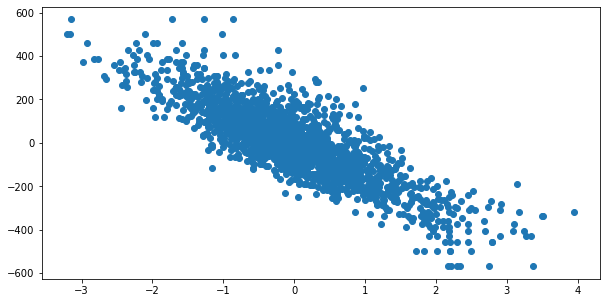

In [71]:
plt.scatter(X_train[0],y_train)

In [129]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1],
    'tweedie_variance_power':[1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
}

xg_reg = xgb.XGBRegressor(objective ='reg:tweedie',nthread= -1,gpu_id=-1)

In [130]:
folds = 5
param_comb = 10

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=1,
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train,sample_weight = w)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/koeunlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [          nan  -43.55373646           nan -167.7412159   -36.68151291
 -176.24270589  -43.43161756 -154.56399119  -45.29781207  -42.99572498]
  category=UserWarning



 Time taken: 0 hours 0 minutes and 37.2 seconds.


In [131]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X_train)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd05.csv', index=False)


 All results:
{'mean_fit_time': array([0.07313237, 2.62314911, 0.02958546, 0.9614872 , 6.93625884,
       1.96770773, 2.53897901, 7.21212592, 2.06846094, 2.97309599]), 'std_fit_time': array([0.00782962, 0.33470923, 0.0020383 , 0.00631993, 0.49244362,
       0.12330748, 0.26349724, 0.05110777, 0.02216157, 0.86649357]), 'mean_score_time': array([0.        , 0.006076  , 0.        , 0.00578523, 0.00683885,
       0.00678105, 0.00589142, 0.0074636 , 0.00505805, 0.0050406 ]), 'std_score_time': array([0.        , 0.00090699, 0.        , 0.00038701, 0.00046368,
       0.00127921, 0.00099746, 0.00107359, 0.0005672 , 0.00093209]), 'param_tweedie_variance_power': masked_array(data=[2, 1.7, 2, 1.6, 1.5, 1.4, 1.4, 1.8, 1.6, 1.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.6, 1.0, 0.6, 0.6, 0.8, 0.6, 0.6, 0.8, 1.0, 1.0],
             mask=[False



Best Train R_squared 5-fold search with 10 parameter combinations:
0.9605004278100548


Best Test R_squared 5-fold search with 10 parameter combinations:
0.837813687994075


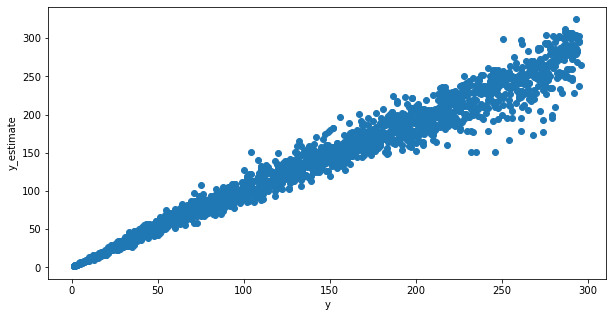

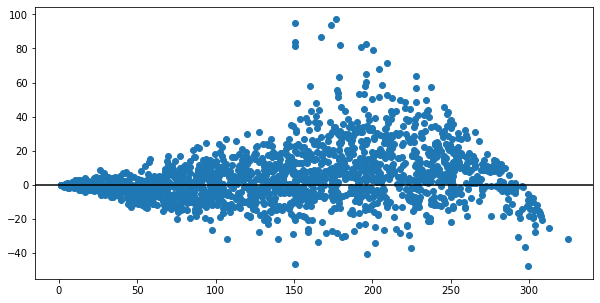

In [132]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X),y-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

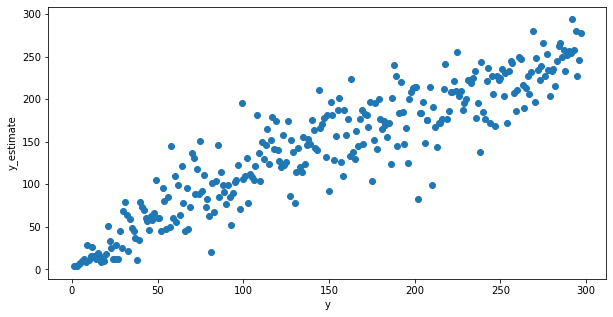

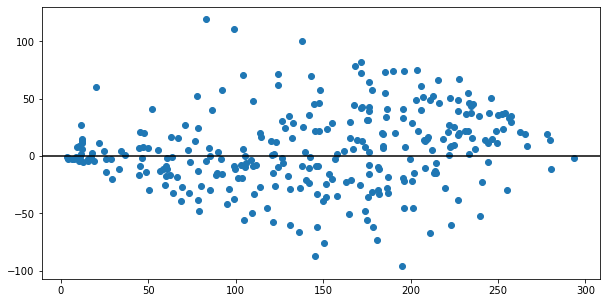

In [133]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y_test,random_search1.predict(X_test))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X_test),y_test-random_search1.predict(X_test))
plt.axhline(color='black')
plt.show()

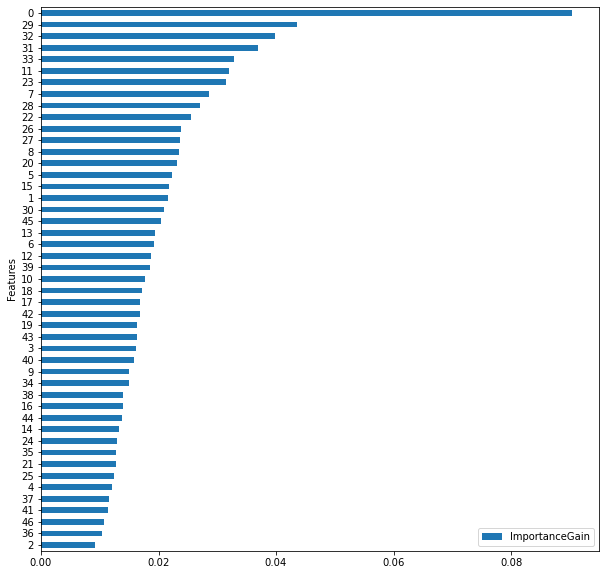

,Features,ImportanceGain,CummulativeGain
0,0,0.090415,0.090415
29,29,0.043513,0.133928
32,32,0.039896,0.173824
31,31,0.036885,0.210709
33,33,0.032813,0.243522
11,11,0.031999,0.275522
23,23,0.031491,0.307013
7,7,0.028652,0.335665
28,28,0.027086,0.362751
22,22,0.025572,0.388323


In [134]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1

### Bootstrap resampling to obtain the predicted RPI distribution

In [135]:
print(random_search1.best_estimator_)
print(random_search1.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:tweedie', random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=None, subsample=0.8, tree_method='exact',
             tweedie_variance_power=1.5, validate_parameters=1, verbosity=None)
{'tweedie_variance_power': 1.5, 'subsample': 0.8, 'reg_alpha': 0, 'random_state': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


In [140]:
best_xgbmodel = random_search1.best_estimator_
best_xgbmodel.fit(X_train,y_train,sample_weight = w)
fname = 'XGBoost_RPI/xgbmodel_rpi.obj'
file = open(fname,'wb')
pickle.dump(best_xgbmodel,file)

In [141]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100
best_xgbmodel_i = random_search1.best_estimator_

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_train)), replace=True, n_samples=len(y_train))
    X_i = X_train.iloc[idx_resample]
    y_i = y_train.iloc[idx_resample]
    w_i = w.iloc[idx_resample]
    best_xgbmodel_i.fit(X_i,y_i,sample_weight = w_i)
    y_ex_est = pd.Series(best_xgbmodel_i.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    #fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    #file_i = open(fname_i,'wb')
    #pickle.dump(best_xgbmodel,file_i)

df_y_ex.columns = X_College_2019

In [10]:
'''
n_bootstrap = 100

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    file_i = open(fname_i,'rb')
    best_xgbmodel = pickle.load(file_i)
    y_ex_est = pd.Series(best_xgbmodel.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    
df_y_ex.columns = X_College_2019
'''

In [142]:
df_y_rank = df_y_ex.rank(axis=1)
df_y_rank
df_y_rank.to_csv('Data/RPI_prediction.csv',index = False)

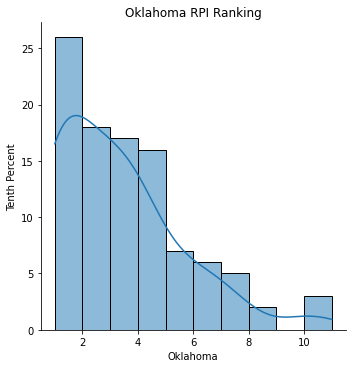

Actual rank:  1.0
Predicted rank:  1.0


In [154]:
idx_ex = 0
college = df_y_rank.columns[idx_ex]
bins = int(np.max(df_y_rank[college]) - np.min(df_y_rank[college]))
sn.displot(data=df_y_rank,x=college,kde=True,bins=bins) 
plt.title(college + ' RPI Ranking')
plt.ylabel('Tenth Percent')
plt.show()
print('Actual rank: ', y_ex[idx_ex])
print('Predicted rank: ',df_y_rank[college].value_counts().idxmax())

In [144]:
df_y_rank

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,3.0,2.0,10.0,4.0,14.0,15.0,6.0,29.0,7.0,26.0,25.0,17.0,11.0,23.0,19.0,16.0,8.0,21.0,18.0,33.0,35.0,28.0,12.0,9.0,30.0,5.0,40.0,20.0,56.0,54.0,47.0,22.0,42.0,36.0,38.0,32.0,13.0,24.0,52.0,59.0,78.0,48.0,60.0,31.0,62.0,43.0,63.0,88.0,64.0,44.0,37.0,66.0,67.0,45.0,85.0,41.0,175.0,39.0,119.0,55.0,106.0,46.0,126.0,57.0,34.0,103.0,51.0,69.0,97.0,154.0,95.0,99.0,86.0,142.0,68.0,94.0,61.0,74.0,50.0,27.0,82.0,53.0,76.0,140.0,72.0,100.0,89.0,70.0,71.0,91.0,77.0,49.0,92.0,80.0,84.0,104.0,65.0,138.0,115.0,87.0,116.0,58.0,73.0,83.0,75.0,101.0,204.0,105.0,79.0,160.0,111.0,171.0,189.0,81.0,150.0,192.0,139.0,213.0,145.0,141.0,125.0,162.0,107.0,120.0,...,134.0,214.0,109.0,149.0,201.0,133.0,203.0,164.0,169.0,194.0,168.0,163.0,193.0,128.0,200.0,234.0,274.0,179.0,196.0,247.0,211.0,166.0,146.0,123.0,237.0,241.0,250.0,227.0,239.0,98.0,187.0,191.0,235.0,156.0,181.0,182.0,233.0,112.0,210.0,195.0,135.0,198.0,208.0,219.0,212.0,264.0,197.0,253.0,207.0,254.0,245.0,216.0,266.0,188.0,220.0,190.0,186.0,209.0,232.0,243.0,261.0,259.0,267.0,176.0,221.0,165.0,246.0,217.0,202.0,242.0,230.0,177.0,273.0,224.0,155.0,238.0,268.0,244.0,288.0,240.0,281.0,170.0,272.0,262.0,279.0,256.0,223.0,229.0,257.0,228.0,248.0,222.0,225.0,280.0,226.0,285.0,269.0,271.0,29

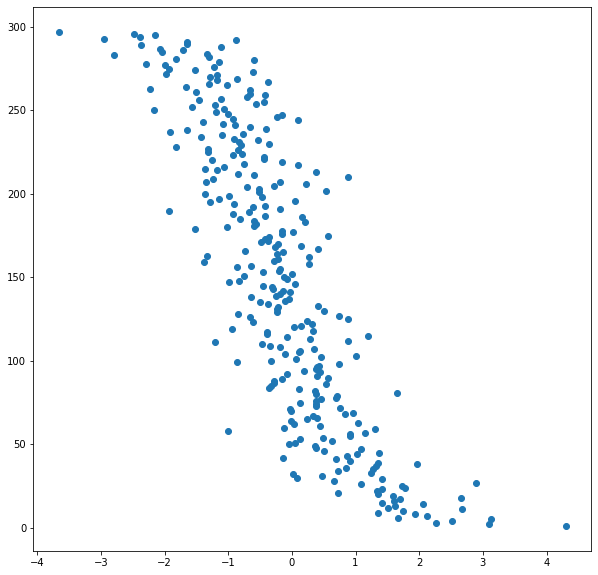

In [115]:
plt.scatter(X_famd_2019[0],y_RPI_2019)

In [43]:
y_prop = y_RPI_2019.copy()/max(y_RPI_2019.copy())
y_scaled = np.log(y_prop/(1-y_prop))


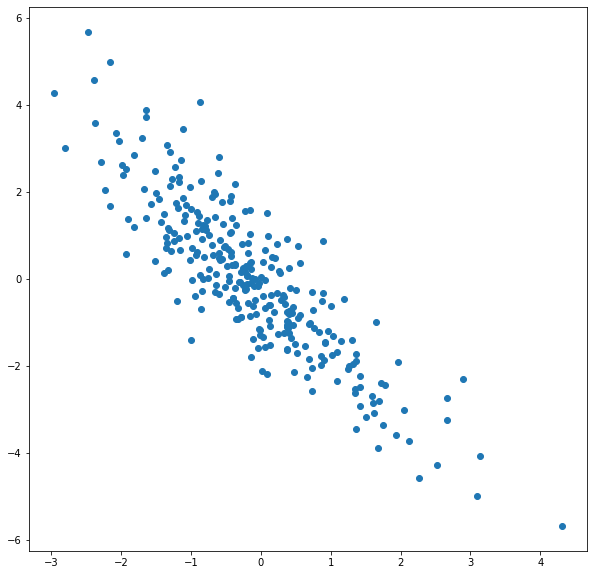

In [116]:
plt.scatter(X_famd_2019[0],y_scaled)

In [146]:
df_y_rank[college].value_counts().idxmax()

1.0